<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_bandas_simulaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4.780790090560913 s.  en 3 simulaciones para N=10e4


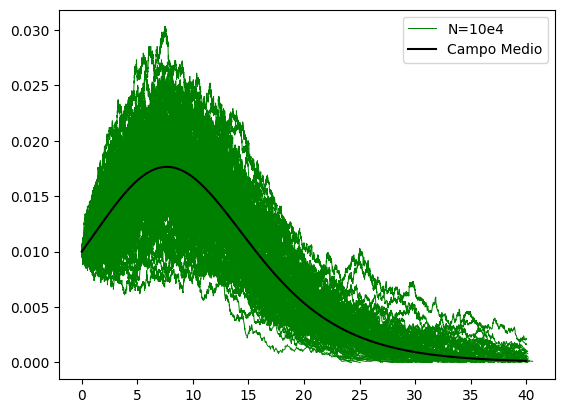

7.096346855163574 s. en total


In [103]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

def Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=np.inf):
  X_S,X_I,X_R=S_0,I_0,R_0
  t=0
  H=[[0,X_S,X_I]]
  while(X_I>0 and t<T):
    lammbda_inf=(beta/N)*X_S*X_I
    lammbda_rec=gamma*X_I
    lammmbda_tol=lammbda_inf+lammbda_rec
    t+=np.random.exponential(scale=1/(lammmbda_tol))
    u_2=np.random.uniform(0,1)
    if(u_2<lammbda_inf/lammmbda_tol):#Infeccion
        X_I+=1
        X_S-=1
    else:#Recuperación
        X_I-=1
        X_R+=1
    H.append([t,X_S,X_I])
  return pd.DataFrame(H,columns=['time','S(t)','I(t)'])
## Ejemplo
start_0=time.time()
np.random.seed(0)
k=100
for power in [4]:
  start_1=time.time()
  beta=1.15
  gamma=1
  N=10**power
  p_i_0=0.01
  I_0=int(p_i_0*N)
  S_0=N-I_0
  R_0=0
  colores=['green','orange','purple']
  Info_bandas=[]
  for iter in range(k):
    if(iter==0):
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
      plt.plot(H['time'],H['I(t)']/N,colores[int(power-4)],linewidth=0.7,label='N=10e'+str(power))
    else:
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
      plt.plot(H['time'],H['I(t)']/N,colores[int(power-4)],linewidth=0.7)
    Info_bandas.append([H['time'],H['I(t)']/N])
  print(time.time()-start_1, "s.  en 3 simulaciones para N=10e"+str(power))
#----------------------------------Campo Medio
from scipy.integrate import odeint
import scipy.integrate as spi
def ode_SIR(INP,t,ps): #Codigo hurtado del dropbox.
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL[:,1]

INPUT = (S_0, I_0, 0.0)
t_start = 0.0; t_end = 40; t_inc = .01
t_range = np.arange(t_start, t_end+t_inc, t_inc)
plt.plot(t_range,g(t_range,INPUT,[beta,gamma,N])/N, 'k',label='Campo Medio')
#----------------------------------
plt.legend()
plt.savefig('markoviano_convergencia.png',dpi=300)
plt.show()
print(time.time()-start_0, 's. en total')

In [114]:
def suma_por_particion(tiempos,base):
  t_0=0
  R=[]
  ultimo_renglon=0
  for t_i in tiempos:
    #print(t_i)
    cuenta=0
    num_cuentas=0
    while((base['time'][ultimo_renglon]<=t_i)):
      num_cuentas+=1
      cuenta+=base['I(t)/n'][ultimo_renglon]
      if(ultimo_renglon<len(base)-1):
        ultimo_renglon+=1
      else:
        break
      #print(base['time'][ultimo_renglon])
      #print(base['time'][ultimo_renglon]<=t_i)
    R.append(cuenta/num_cuentas if num_cuentas>0 else 0)
    #print(R)
  return(R)

In [3]:
def concat(array_arrays):
  resulting_list = list(array_arrays[0])
  for arr_i in array_arrays[1:]:
    resulting_list.extend(x for x in arr_i if x not in resulting_list)
  return resulting_list
times__=[]
for i in range(k):
  times__.append(Info_bandas[i][0].to_list())
times_union=concat(times__)
times_union=np.sort(times_union)

In [118]:
R_s=[]
for i in range(k):
  base=pd.DataFrame(np.transpose(Info_bandas[i]),columns=['time','I(t)/n'])
  R_s.append(suma_por_particion(tiempos=np.linspace(0.01,35,700),base=base))
R_s=pd.DataFrame(R_s)

In [58]:
R_s

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
0,0.0297,0.1872,0.1337,0.2599,0.2132,0.2340,0.2562,0.2138,0.3351,0.2685,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0400,0.3262,0.2743,0.2661,0.2364,0.3575,0.2150,0.2047,0.2130,0.2924,...,0.0003,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0201,0.2204,0.3462,0.2114,0.2220,0.3475,0.2715,0.2370,0.2053,0.2648,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
mean_by_time=R_s.mean(axis=0)
q_p95=R_s.quantile(0.95,axis=0)
q_p5=R_s.quantile(0.05,axis=0)

[]

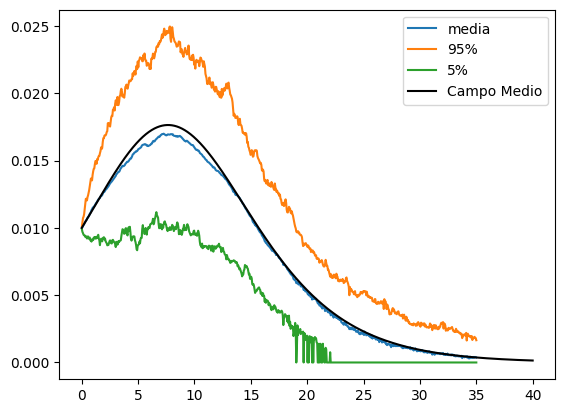

In [123]:
plt.plot(np.linspace(0.01,35,700),mean_by_time,label='media')
plt.plot(np.linspace(0.01,35,700),q_p95,label='95%')
plt.plot(np.linspace(0.01,35,700),q_p5,label='5%')
plt.plot(t_range,g(t_range,INPUT,[beta,gamma,N])/N, 'k',label='Campo Medio')
#----------------------------------
plt.legend()
plt.plot()